# Part 1C: Composite Score Analysis

**Objective:** Analyze which of the 7 squad-level composite score categories predict final league position.

**Key Questions:**
1. Which composite categories best predict final position?
2. Are any categories redundant (highly correlated)?
3. What scores separate Top 4 from relegation?
4. Why is Arsenal dominating GW7?
5. Which categories should we prioritize for ML modeling?

**Data:**
- Historical: 3 recent complete seasons with GW38 final positions
- Current: 2025-2026 season at GW7
- Categories: 7 squad composite scores (attacking_output, creativity, defending, ball_progression, physical_duels, passing, possession)

## Section 1: Setup and Data Loading

In [44]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import sys
import warnings
warnings.filterwarnings('ignore')

# Add project root to path to import SquadAnalyzer
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("=" * 80)
print("PART 1C: COMPOSITE SCORE ANALYSIS")
print("=" * 80)
print(f"⏰ Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

# Database path (will connect after SquadAnalyzer to avoid conflicts)
db_path = str(project_root / "data" / "premierleague_analytics.duckdb")
print(f"✅ Database: {db_path}")
print()

PART 1C: COMPOSITE SCORE ANALYSIS
⏰ Analysis started: 2025-10-19 14:01:33

✅ Database: /Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/data/premierleague_analytics.duckdb



## Section 2: Define Seasons to Analyze

In [45]:
print("📅 Defining Historical Seasons to Analyze...")
print("-" * 80)

# Temporarily connect to get available seasons
conn_temp = duckdb.connect(db_path, read_only=True)

# Get available seasons with GW38 data (completed seasons)
available_seasons = conn_temp.execute("""
    SELECT DISTINCT season
    FROM analytics_squads
    WHERE gameweek = 38
    ORDER BY season DESC
""").fetchdf()

# Close temporary connection to avoid conflicts with SquadAnalyzer
conn_temp.close()

print(f"Available complete seasons: {len(available_seasons)}")
for season in available_seasons['season']:
    print(f"  - {season}")
print()

# Choose recent seasons to analyze
seasons_to_analyze = available_seasons['season'].head(5).tolist()

print(f"📊 Analyzing these {len(seasons_to_analyze)} recent seasons:")
for season in seasons_to_analyze:
    print(f"  ✅ {season}")
print()

print(f"💡 Note: Using recent seasons for faster analysis.")
print(f"   You can expand to all {len(available_seasons)} seasons later if needed.")
print()

📅 Defining Historical Seasons to Analyze...
--------------------------------------------------------------------------------
Available complete seasons: 15
  - 2024-2025
  - 2023-2024
  - 2022-2023
  - 2021-2022
  - 2020-2021
  - 2019-2020
  - 2018-2019
  - 2017-2018
  - 2016-2017
  - 2015-2016
  - 2014-2015
  - 2013-2014
  - 2012-2013
  - 2011-2012
  - 2010-2011

📊 Analyzing these 5 recent seasons:
  ✅ 2024-2025
  ✅ 2023-2024
  ✅ 2022-2023
  ✅ 2021-2022
  ✅ 2020-2021

💡 Note: Using recent seasons for faster analysis.
   You can expand to all 15 seasons later if needed.



## Section 3: Import SquadAnalyzer and Define Categories

In [46]:
print("📊 Loading SquadAnalyzer...")
print("-" * 80)

try:
    from analysis.squad_analyzer import SquadAnalyzer
    
    # Initialize analyzer
    analyzer = SquadAnalyzer(db_path=db_path)
    analyzer.connect()
    
    print("✅ SquadAnalyzer loaded successfully")
    
    # Get the 7 squad composite categories (not 8 - that's for players)
    categories = list(analyzer.stat_categories.keys())
    
    print(f"\n📋 Analyzing {len(categories)} squad composite categories:")
    for i, cat in enumerate(categories, 1):
        print(f"   {i}. {cat}")
    print()
    
except Exception as e:
    print(f"❌ Could not load SquadAnalyzer: {e}")
    raise

print()

📊 Loading SquadAnalyzer...
--------------------------------------------------------------------------------
✅ SquadAnalyzer loaded successfully

📋 Analyzing 7 squad composite categories:
   1. attacking_output
   2. creativity
   3. passing
   4. ball_progression
   5. defending
   6. physical_duels
   7. possession




## Section 4: Calculate Composite Scores for All Seasons

In [47]:
print("=" * 80)
print("SECTION 4: CALCULATING COMPOSITE SCORES (Season-by-Season)")
print("=" * 80)
print()

print("This will take 2-5 minutes...")
print(f"Processing: {len(seasons_to_analyze)} seasons × {len(categories)} categories × 20 teams")
print(f"Total calculations: {len(seasons_to_analyze) * len(categories) * 20}")
print()

# Store all composite scores
all_composite_scores = []

# Loop through each season
for season_idx, season in enumerate(seasons_to_analyze, 1):
    print(f"[{season_idx}/{len(seasons_to_analyze)}] Processing season {season}...")
    
    timeframe = f"season_{season}"
    
    # Loop through each category
    for cat_idx, category in enumerate(categories, 1):
        try:
            # Calculate composite scores for this category in this season
            # This automatically ranks teams 1-20 WITHIN this season
            scores_df = analyzer.calculate_category_composite_scores(
                category=category,
                timeframe=timeframe
            )
            
            if not scores_df.empty:
                # Add season and category columns
                scores_df['season'] = season
                scores_df['category'] = category
                
                # Store
                all_composite_scores.append(scores_df)
                
                # Progress indicator
                if cat_idx % 3 == 0:  # Print every 3 categories
                    print(f"  ✓ Processed {cat_idx}/{len(categories)} categories for {season}")
        
        except Exception as e:
            print(f"  ⚠️  Error calculating {category} for {season}: {e}")
            continue
    
    print(f"  ✅ Completed {season}")
    print()

# Combine all results
if all_composite_scores:
    composite_df = pd.concat(all_composite_scores, ignore_index=True)
    print(f"✅ Successfully calculated composite scores!")
    print(f"   Total records: {len(composite_df)}")
    print(f"   Seasons: {composite_df['season'].nunique()}")
    print(f"   Categories: {composite_df['category'].nunique()}")
    print(f"   Unique squads: {composite_df['squad_name'].nunique()}")
else:
    print("❌ No composite scores calculated!")
    raise Exception("Failed to calculate composite scores")

print()

# Disconnect analyzer
analyzer.disconnect()

SECTION 4: CALCULATING COMPOSITE SCORES (Season-by-Season)

This will take 2-5 minutes...
Processing: 5 seasons × 7 categories × 20 teams
Total calculations: 700

[1/5] Processing season 2024-2025...
  ✓ Processed 3/7 categories for 2024-2025
  ✓ Processed 6/7 categories for 2024-2025
  ✅ Completed 2024-2025

[2/5] Processing season 2023-2024...
  ✓ Processed 3/7 categories for 2023-2024
  ✓ Processed 6/7 categories for 2023-2024
  ✅ Completed 2023-2024

[3/5] Processing season 2022-2023...
  ✓ Processed 3/7 categories for 2022-2023
  ✓ Processed 6/7 categories for 2022-2023
  ✅ Completed 2022-2023

[4/5] Processing season 2021-2022...
  ✓ Processed 3/7 categories for 2021-2022
  ✓ Processed 6/7 categories for 2021-2022
  ✅ Completed 2021-2022

[5/5] Processing season 2020-2021...
  ✓ Processed 3/7 categories for 2020-2021
  ✓ Processed 6/7 categories for 2020-2021
  ✅ Completed 2020-2021

✅ Successfully calculated composite scores!
   Total records: 700
   Seasons: 5
   Categories: 7


## Section 5: Load Historical Match Results with Final Positions

In [50]:
print("=" * 80)
print("SECTION 5: LOADING HISTORICAL MATCH RESULTS")
print("=" * 80)
print()

# Reconnect to database (SquadAnalyzer has disconnected by now)
conn = duckdb.connect(db_path, read_only=True)

# Load historical season-end data with final positions
historical = conn.execute("""
    SELECT 
        season,
        squad_name,
        gameweek,
        matches_played,
        goals,
        goals_against,
        (goals - goals_against) as goal_difference,
        wins,
        draws,
        losses,
        (wins * 3 + draws) as points
    FROM analytics_squads
    WHERE gameweek = 38
        AND season IN (?, ?, ?, ?, ?)
    ORDER BY season DESC, points DESC
""", seasons_to_analyze).fetchdf()

print(f"✅ Loaded {len(historical)} historical squad records")
print()

# Calculate final position WITHIN each season
historical['final_position'] = historical.groupby('season')['points'].rank(
    method='min', ascending=False
).astype(int)

# Assign tiers
def get_tier(position):
    if position <= 4:
        return 'Top 4'
    elif position <= 10:
        return 'Upper Mid-Table (5-10)'
    elif position <= 17:
        return 'Lower Mid-Table (11-17)'
    else:
        return 'Relegation Zone (18-20)'

historical['tier'] = historical['final_position'].apply(get_tier)

# Display tier distribution
print("📊 Tier Distribution Across Seasons:")
tier_dist = historical.groupby(['season', 'tier']).size().unstack(fill_value=0)
print(tier_dist)
print()

SECTION 5: LOADING HISTORICAL MATCH RESULTS

✅ Loaded 100 historical squad records

📊 Tier Distribution Across Seasons:
tier       Lower Mid-Table (11-17)  Relegation Zone (18-20)  Top 4  \
season                                                               
2020-2021                        7                        3      4   
2021-2022                        7                        3      4   
2022-2023                        7                        3      4   
2023-2024                        7                        3      4   
2024-2025                        7                        3      4   

tier       Upper Mid-Table (5-10)  
season                             
2020-2021                       6  
2021-2022                       6  
2022-2023                       6  
2023-2024                       6  
2024-2025                       6  



## Section 6: Merge Composite Scores with Historical Results

In [51]:
print("=" * 80)
print("SECTION 6: MERGING COMPOSITE SCORES WITH HISTORICAL RESULTS")
print("=" * 80)
print()

# Pivot composite scores to wide format (one row per squad per season)
composite_wide = composite_df.pivot_table(
    index=['season', 'squad_name'],
    columns='category',
    values='composite_score',
    aggfunc='first'
).reset_index()

# Rename columns to add '_score' suffix
composite_wide.columns = [f"{col}_score" if col not in ['season', 'squad_name'] else col 
                          for col in composite_wide.columns]

print(f"✅ Pivoted composite scores to wide format")
print(f"   Shape: {composite_wide.shape}")
print()

# Merge with historical data
historical_with_composites = historical.merge(
    composite_wide,
    on=['season', 'squad_name'],
    how='left'
)

print(f"✅ Merged composite scores with historical data")
print(f"   Final shape: {historical_with_composites.shape}")
print()

# Check for missing composite scores
composite_cols = [col for col in historical_with_composites.columns if col.endswith('_score')]
print(f"📊 Composite score columns: {len(composite_cols)}")

missing_summary = []
for col in composite_cols:
    missing = historical_with_composites[col].isna().sum()
    missing_pct = (missing / len(historical_with_composites)) * 100
    missing_summary.append({
        'category': col.replace('_score', ''),
        'missing': missing,
        'missing_pct': missing_pct
    })

missing_df = pd.DataFrame(missing_summary)
if missing_df['missing'].sum() > 0:
    print("\n⚠️  Missing composite scores:")
    print(missing_df[missing_df['missing'] > 0])
else:
    print("✅ No missing composite scores!")

print()

SECTION 6: MERGING COMPOSITE SCORES WITH HISTORICAL RESULTS

✅ Pivoted composite scores to wide format
   Shape: (100, 9)

✅ Merged composite scores with historical data
   Final shape: (100, 20)

📊 Composite score columns: 7
✅ No missing composite scores!



## Section 7: Composite Score Distributions by Tier

In [52]:
print("=" * 80)
print("SECTION 7: COMPOSITE SCORE DISTRIBUTIONS BY TIER")
print("=" * 80)
print()

# Create output directory
output_dir = Path("../../outputs/03_composite_scores_analysis")
output_dir.mkdir(parents=True, exist_ok=True)

tier_order = ['Top 4', 'Upper Mid-Table (5-10)', 'Lower Mid-Table (11-17)', 'Relegation Zone (18-20)']

# Calculate mean scores by tier for each category
print("📊 MEAN COMPOSITE SCORES BY TIER")
print("-" * 80)

tier_means = {}
for col in composite_cols:
    tier_means[col] = historical_with_composites.groupby('tier')[col].mean()

tier_means_df = pd.DataFrame(tier_means).T
tier_means_df.columns = tier_order
tier_means_df.index = [idx.replace('_score', '') for idx in tier_means_df.index]

print(tier_means_df.round(1))
print()

# Identify which categories show biggest separation
print("💡 CATEGORY SEPARATION ANALYSIS (Top 4 vs Relegation)")
print("-" * 80)

separations = {}
for col in composite_cols:
    top4_mean = historical_with_composites[historical_with_composites['tier'] == 'Top 4'][col].mean()
    relegation_mean = historical_with_composites[historical_with_composites['tier'] == 'Relegation Zone (18-20)'][col].mean()
    separation = top4_mean - relegation_mean
    separations[col] = separation
    
# Sort by separation (largest first)
separations_sorted = sorted(separations.items(), key=lambda x: x[1], reverse=True)

print("Categories ranked by Top 4 vs Relegation gap (higher = more predictive):")
for i, (category, sep) in enumerate(separations_sorted, 1):
    category_name = category.replace('_score', '')
    print(f"  {i}. {category_name:<25} Gap: {sep:>6.1f} points")

print()

SECTION 7: COMPOSITE SCORE DISTRIBUTIONS BY TIER

📊 MEAN COMPOSITE SCORES BY TIER
--------------------------------------------------------------------------------
                  Top 4  Upper Mid-Table (5-10)  Lower Mid-Table (11-17)  \
attacking_output   32.5                    18.2                     74.3   
ball_progression   38.9                    31.0                     64.2   
creativity         34.6                    21.7                     66.0   
defending          51.6                    46.3                     50.2   
passing            40.1                    34.7                     59.2   
physical_duels     46.7                    47.2                     55.1   
possession         44.7                    43.8                     50.5   

                  Relegation Zone (18-20)  
attacking_output                     52.0  
ball_progression                     47.0  
creativity                           45.7  
defending                            52.2  
passing 

## Section 8: Visualize Composite Scores by Tier

📊 Creating Composite Score Visualizations...
--------------------------------------------------------------------------------
✅ Saved: composite_scores_by_tier.png


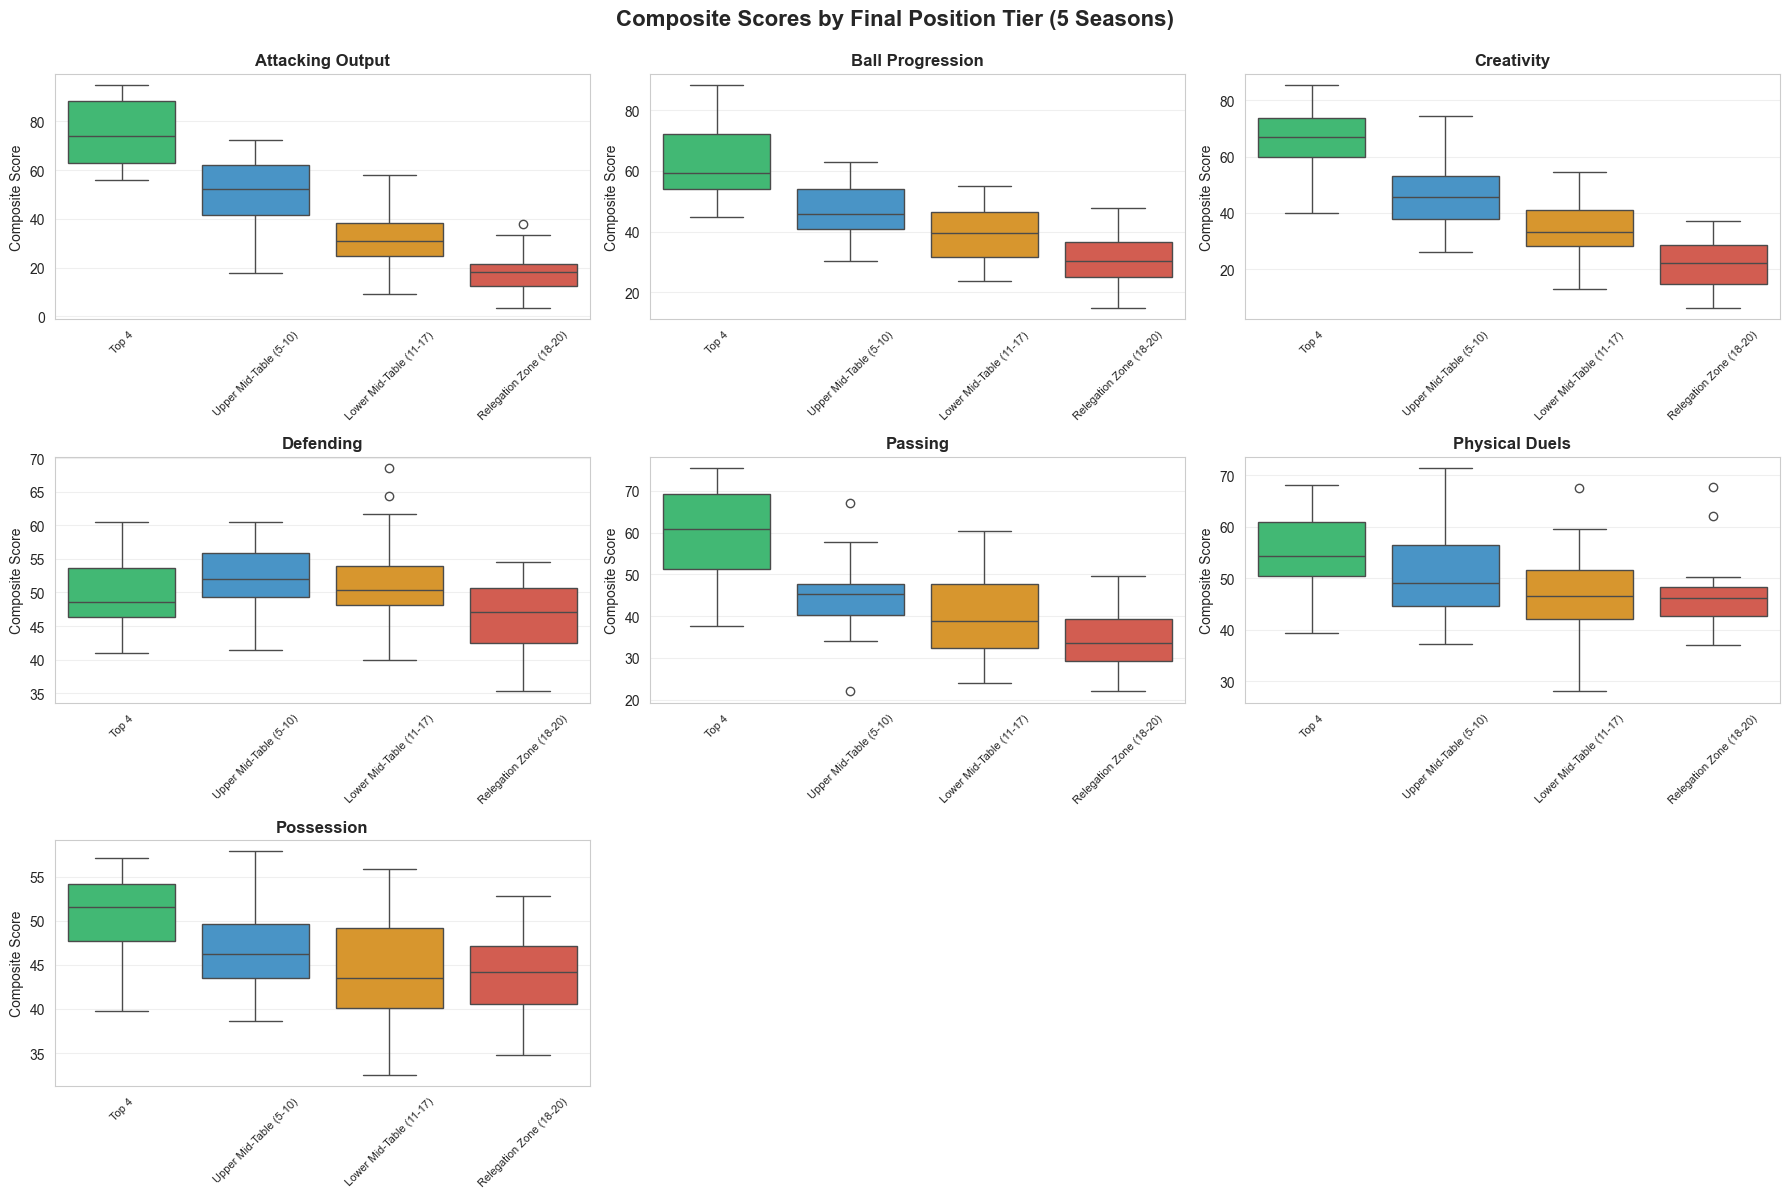

In [53]:
print("📊 Creating Composite Score Visualizations...")
print("-" * 80)

# Determine grid size based on number of categories
n_categories = len(composite_cols)
n_cols = 3  # 3 columns
n_rows = (n_categories + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_categories > 1 else [axes]

tier_colors = {
    'Top 4': '#2ecc71',
    'Upper Mid-Table (5-10)': '#3498db',
    'Lower Mid-Table (11-17)': '#f39c12',
    'Relegation Zone (18-20)': '#e74c3c'
}

for idx, col in enumerate(composite_cols):
    ax = axes[idx]
    
    # Create box plot
    sns.boxplot(
        data=historical_with_composites,
        x='tier',
        y=col,
        order=tier_order,
        palette=tier_colors,
        ax=ax
    )
    
    # Formatting
    category_name = col.replace('_score', '').replace('_', ' ').title()
    ax.set_title(category_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Composite Score', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(True, alpha=0.3, axis='y')

# Hide unused subplots
for idx in range(len(composite_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Composite Scores by Final Position Tier ({len(seasons_to_analyze)} Seasons)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir / "composite_scores_by_tier.png", dpi=300, bbox_inches='tight')
print("✅ Saved: composite_scores_by_tier.png")
plt.show()

print()

## Section 9: Correlation with Final Position

In [54]:
print("=" * 80)
print("SECTION 9: CORRELATION WITH FINAL POSITION")
print("=" * 80)
print()

# Calculate correlation between each composite score and final position
# Note: Negative correlation = higher score → better (lower) position
correlations = {}

for col in composite_cols:
    # Drop NaN values for correlation
    valid_data = historical_with_composites[[col, 'final_position']].dropna()
    
    if len(valid_data) > 0:
        corr = valid_data[col].corr(valid_data['final_position'])
        correlations[col] = corr

# Sort by absolute correlation (strongest predictors first)
correlations_sorted = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("📊 CORRELATION WITH FINAL POSITION")
print("-" * 80)
print("(Negative correlation = higher score → better position)")
print()
print(f"{'Category':<30} {'Correlation':<15} {'Strength'}")
print("-" * 80)

for category, corr in correlations_sorted:
    category_name = category.replace('_score', '')
    
    # Interpret correlation strength
    if abs(corr) >= 0.7:
        strength = "🔥 Very Strong"
    elif abs(corr) >= 0.5:
        strength = "💪 Strong"
    elif abs(corr) >= 0.3:
        strength = "👍 Moderate"
    else:
        strength = "😐 Weak"
    
    print(f"{category_name:<30} {corr:>8.3f}        {strength}")

print()

# Identify top predictors
top_predictors = [cat for cat, corr in correlations_sorted if abs(corr) >= 0.5]
weak_predictors = [cat for cat, corr in correlations_sorted if abs(corr) < 0.3]

print(f"💡 KEY INSIGHT:")
print(f"   🔥 {len(top_predictors)} strong predictors (|r| ≥ 0.5): {[c.replace('_score', '') for c in top_predictors]}")
print(f"   😐 {len(weak_predictors)} weak predictors (|r| < 0.3): {[c.replace('_score', '') for c in weak_predictors]}")
print(f"\n   👉 Focus ML models on the {len(top_predictors)} strong predictors!")
print()

SECTION 9: CORRELATION WITH FINAL POSITION

📊 CORRELATION WITH FINAL POSITION
--------------------------------------------------------------------------------
(Negative correlation = higher score → better position)

Category                       Correlation     Strength
--------------------------------------------------------------------------------
attacking_output                 -0.869        🔥 Very Strong
creativity                       -0.827        🔥 Very Strong
ball_progression                 -0.754        🔥 Very Strong
passing                          -0.658        💪 Strong
possession                       -0.409        👍 Moderate
physical_duels                   -0.331        👍 Moderate
defending                        -0.167        😐 Weak

💡 KEY INSIGHT:
   🔥 4 strong predictors (|r| ≥ 0.5): ['attacking_output', 'creativity', 'ball_progression', 'passing']
   😐 1 weak predictors (|r| < 0.3): ['defending']

   👉 Focus ML models on the 4 strong predictors!



## Section 10: Category Correlation Matrix (Redundancy Check)

SECTION 10: CATEGORY CORRELATION MATRIX (Redundancy Check)

Checking for redundant categories (high inter-correlation)...

✅ Saved: composite_correlation_matrix.png


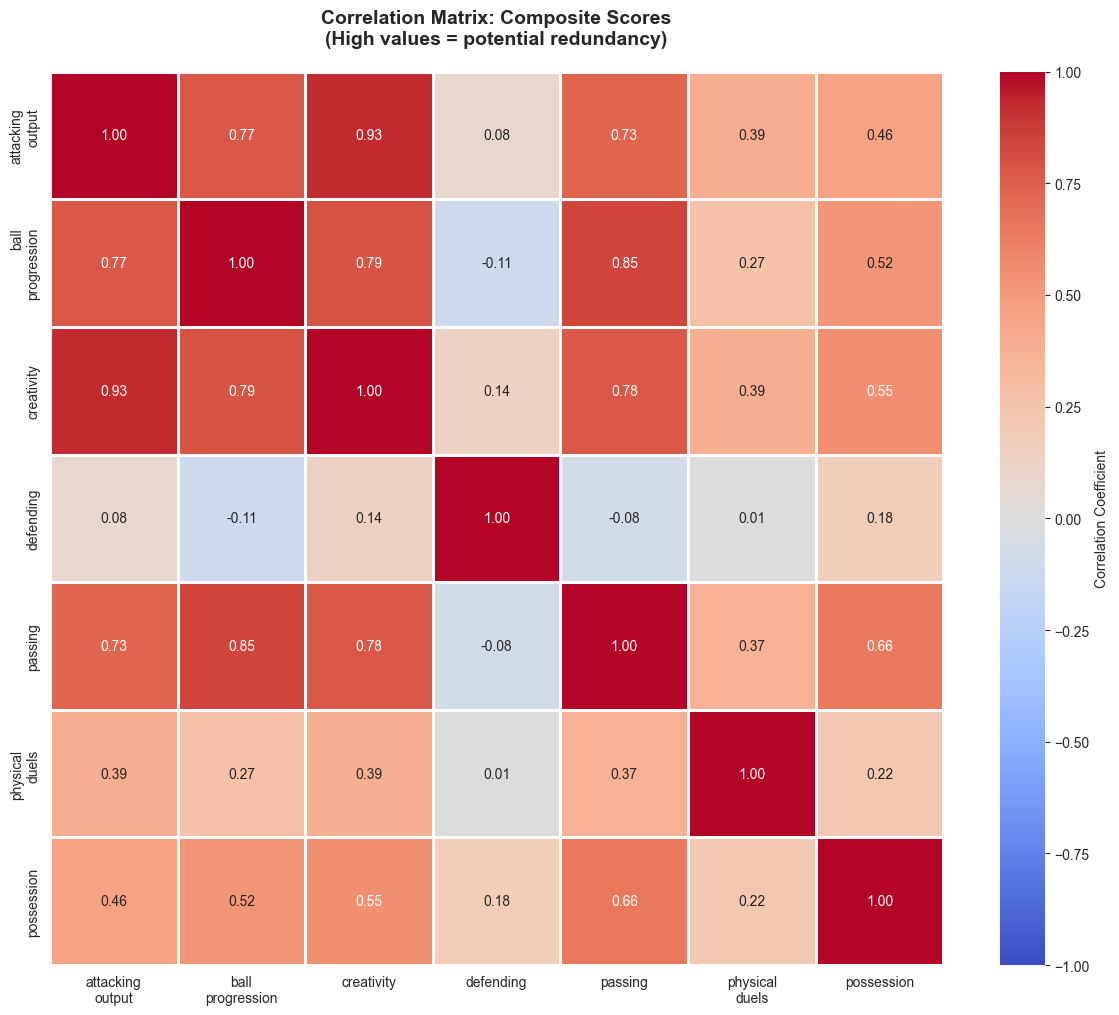


🔍 HIGHLY CORRELATED PAIRS (|r| > 0.70)
--------------------------------------------------------------------------------
  attacking_output ↔ ball_progression: r = 0.774
  attacking_output ↔ creativity: r = 0.929
  attacking_output ↔ passing: r = 0.727
  ball_progression ↔ creativity: r = 0.791
  ball_progression ↔ passing: r = 0.846
  creativity ↔ passing: r = 0.778

💡 Consider removing one category from highly correlated pairs



In [55]:
print("=" * 80)
print("SECTION 10: CATEGORY CORRELATION MATRIX (Redundancy Check)")
print("=" * 80)
print()
print("Checking for redundant categories (high inter-correlation)...")
print()

# Calculate correlation matrix between composite scores
composite_data = historical_with_composites[composite_cols].dropna()

if len(composite_data) > 0:
    corr_matrix = composite_data.corr()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Clean labels (remove '_score' suffix)
    labels = [col.replace('_score', '').replace('_', '\n') for col in composite_cols]
    
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=1,
        cbar_kws={'label': 'Correlation Coefficient'},
        xticklabels=labels,
        yticklabels=labels,
        ax=ax
    )
    
    ax.set_title('Correlation Matrix: Composite Scores\n(High values = potential redundancy)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(output_dir / "composite_correlation_matrix.png", dpi=300, bbox_inches='tight')
    print("✅ Saved: composite_correlation_matrix.png")
    plt.show()
    
    # Identify highly correlated pairs (r > 0.70)
    print("\n🔍 HIGHLY CORRELATED PAIRS (|r| > 0.70)")
    print("-" * 80)
    
    found_high_corr = False
    for i in range(len(composite_cols)):
        for j in range(i+1, len(composite_cols)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.70:
                cat1 = composite_cols[i].replace('_score', '')
                cat2 = composite_cols[j].replace('_score', '')
                print(f"  {cat1} ↔ {cat2}: r = {corr_val:.3f}")
                found_high_corr = True
    
    if not found_high_corr:
        print("  ✅ No highly correlated pairs found")
        print("  👉 All categories are distinct - no redundancy!")
    else:
        print("\n💡 Consider removing one category from highly correlated pairs")

else:
    print("⚠️  Not enough data to calculate correlation matrix")

print()

## Section 11: Current Season Analysis (GW7)

In [56]:
print("=" * 80)
print("SECTION 11: CURRENT SEASON COMPOSITE SCORES (GW7)")
print("=" * 80)
print()

print("Calculating composite scores for current season (2025-2026 GW7)...")

# Close the previous connection from Section 5 to avoid conflicts
conn.close()

# Reconnect analyzer
analyzer.connect()

# Calculate composite scores for current season
current_composites = []

for category in categories:
    try:
        scores_df = analyzer.calculate_category_composite_scores(
            category=category,
            timeframe='current'  # GW7 snapshot
        )
        
        if not scores_df.empty:
            scores_df['category'] = category
            current_composites.append(scores_df)
        
    except Exception as e:
        print(f"⚠️  Could not calculate {category}: {e}")

# Combine
if current_composites:
    current_composite_df = pd.concat(current_composites, ignore_index=True)
    
    # Pivot to wide format
    current_wide = current_composite_df.pivot_table(
        index='squad_name',
        columns='category',
        values='composite_score',
        aggfunc='first'
    ).reset_index()
    
    print(f"✅ Current season composite scores calculated")
    print(f"   Squads: {len(current_wide)}")
    print()
else:
    print("❌ Could not calculate current season scores")
    current_wide = pd.DataFrame()

analyzer.disconnect()

# Show top 5 teams by each category
if not current_wide.empty:
    print("🏆 TOP 5 TEAMS BY CATEGORY (Current Season, GW7)")
    print("-" * 80)
    
    for category in categories:
        if category in current_wide.columns:
            print(f"\n{category.replace('_', ' ').title()}:")
            top5 = current_wide.nlargest(5, category)[['squad_name', category]]
            for idx, row in top5.iterrows():
                print(f"  {row['squad_name']:<20} {row[category]:.1f}")

print()

SECTION 11: CURRENT SEASON COMPOSITE SCORES (GW7)

Calculating composite scores for current season (2025-2026 GW7)...
✅ Current season composite scores calculated
   Squads: 20

🏆 TOP 5 TEAMS BY CATEGORY (Current Season, GW7)
--------------------------------------------------------------------------------

Attacking Output:
  Manchester City      78.7
  Arsenal              72.4
  Liverpool            69.7
  Chelsea              66.2
  Crystal Palace       55.7

Creativity:
  Arsenal              68.2
  Liverpool            56.8
  Manchester Utd       56.0
  Chelsea              55.0
  Bournemouth          51.3

Passing:
  Liverpool            72.8
  Chelsea              68.9
  Manchester City      63.2
  Arsenal              61.6
  Nott'ham Forest      59.3

Ball Progression:
  Arsenal              73.9
  Manchester City      65.9
  Liverpool            61.8
  Bournemouth          61.7
  Nott'ham Forest      57.2

Defending:
  Sunderland           65.8
  Crystal Palace       60.3
  Ev

## Section 12: Arsenal Deep Dive (Why Dominating?)

SECTION 12: ARSENAL ANALYSIS - Why Are They Dominating GW7?

🔍 ARSENAL'S COMPOSITE SCORE PROFILE (GW7)
--------------------------------------------------------------------------------
attacking_output          Score:   72.4  Rank: 2/20
creativity                Score:   68.2  Rank: 1/20
passing                   Score:   61.6  Rank: 4/20
ball_progression          Score:   73.9  Rank: 1/20
defending                 Score:   50.9  Rank: 8/20
physical_duels            Score:   52.0  Rank: 7/20
possession                Score:   52.1  Rank: 7/20

Creating Arsenal composite score radar chart...
✅ Saved: arsenal_composite_profile.png


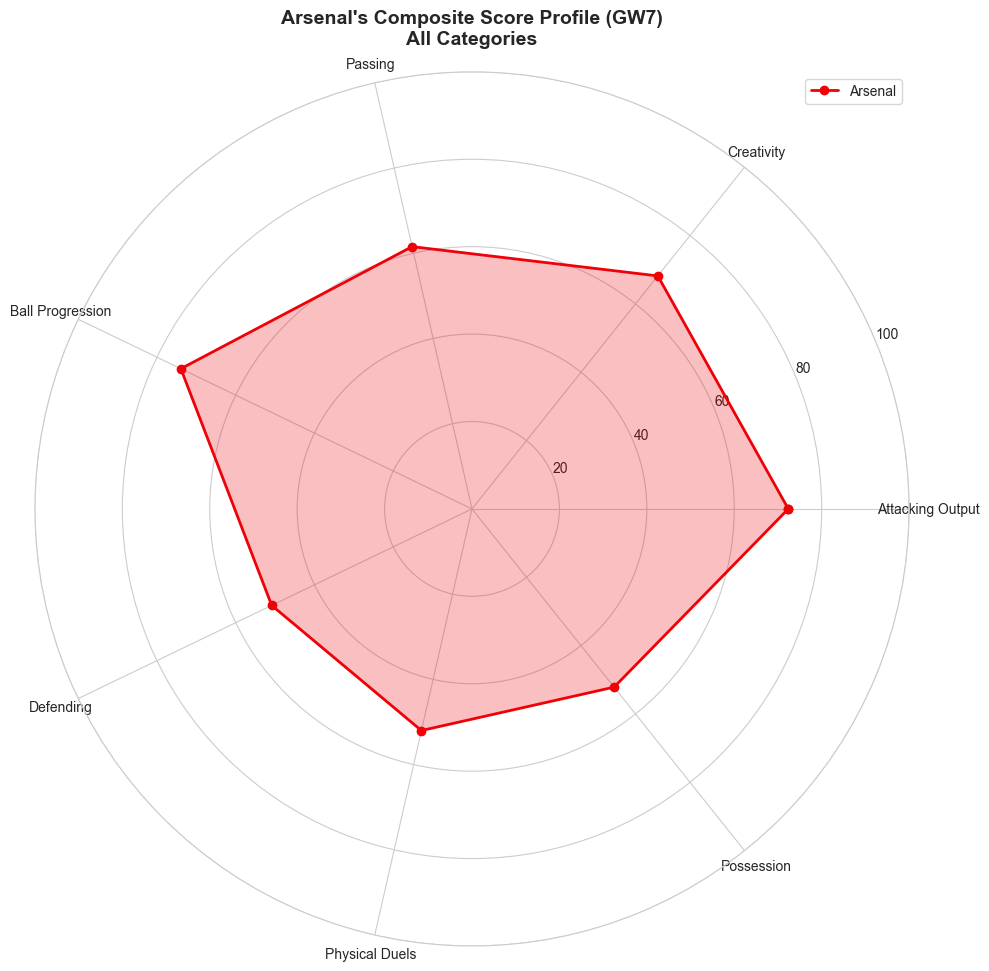


💪 ARSENAL'S STRENGTHS (Top 3):
  Ball Progression          73.9
  Attacking Output          72.4
  Creativity                68.2

⚠️  ARSENAL'S RELATIVE WEAKNESSES (Bottom 3):
  Possession                52.1
  Physical Duels            52.0
  Defending                 50.9



In [57]:
print("=" * 80)
print("SECTION 12: ARSENAL ANALYSIS - Why Are They Dominating GW7?")
print("=" * 80)
print()

# From Part 1B, we know Arsenal leads in goals
if not current_wide.empty and 'Arsenal' in current_wide['squad_name'].values:
    arsenal_row = current_wide[current_wide['squad_name'] == 'Arsenal'].iloc[0]
    
    print("🔍 ARSENAL'S COMPOSITE SCORE PROFILE (GW7)")
    print("-" * 80)
    
    arsenal_scores = {}
    for category in categories:
        if category in current_wide.columns:
            score = arsenal_row[category]
            arsenal_scores[category] = score
            
            # Get rank
            rank = (current_wide[category] > score).sum() + 1
            
            print(f"{category:<25} Score: {score:>6.1f}  Rank: {rank}/20")
    
    print()
    
    # Create radar chart for Arsenal
    if len(arsenal_scores) > 0:
        print("Creating Arsenal composite score radar chart...")
        
        categories_clean = [c.replace('_', ' ').title() for c in arsenal_scores.keys()]
        values = list(arsenal_scores.values())
        
        # Number of variables
        num_vars = len(categories_clean)
        
        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        values += values[:1]  # Complete the circle
        angles += angles[:1]
        
        # Create radar chart
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
        
        ax.plot(angles, values, 'o-', linewidth=2, label='Arsenal', color='#EF0107')
        ax.fill(angles, values, alpha=0.25, color='#EF0107')
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories_clean, size=10)
        ax.set_ylim(0, 100)
        ax.set_title("Arsenal's Composite Score Profile (GW7)\nAll Categories", 
                     fontsize=14, fontweight='bold', pad=20)
        ax.grid(True)
        ax.legend(loc='upper right')
        
        plt.tight_layout()
        plt.savefig(output_dir / "arsenal_composite_profile.png", dpi=300, bbox_inches='tight')
        print("✅ Saved: arsenal_composite_profile.png")
        plt.show()
        
        print()
        
        # Identify Arsenal's strengths and weaknesses
        arsenal_scores_sorted = sorted(arsenal_scores.items(), key=lambda x: x[1], reverse=True)
        
        print("💪 ARSENAL'S STRENGTHS (Top 3):")
        for cat, score in arsenal_scores_sorted[:3]:
            print(f"  {cat.replace('_', ' ').title():<25} {score:.1f}")
        
        print()
        print("⚠️  ARSENAL'S RELATIVE WEAKNESSES (Bottom 3):")
        for cat, score in arsenal_scores_sorted[-3:]:
            print(f"  {cat.replace('_', ' ').title():<25} {score:.1f}")
        
        print()

else:
    print("⚠️  Arsenal data not available for current season")
    print()

## SECTION 13: Comparing multiple teams

SECTION 12B: MULTI-TEAM COMPARISON

✅ Saved: top_teams_comparison.png


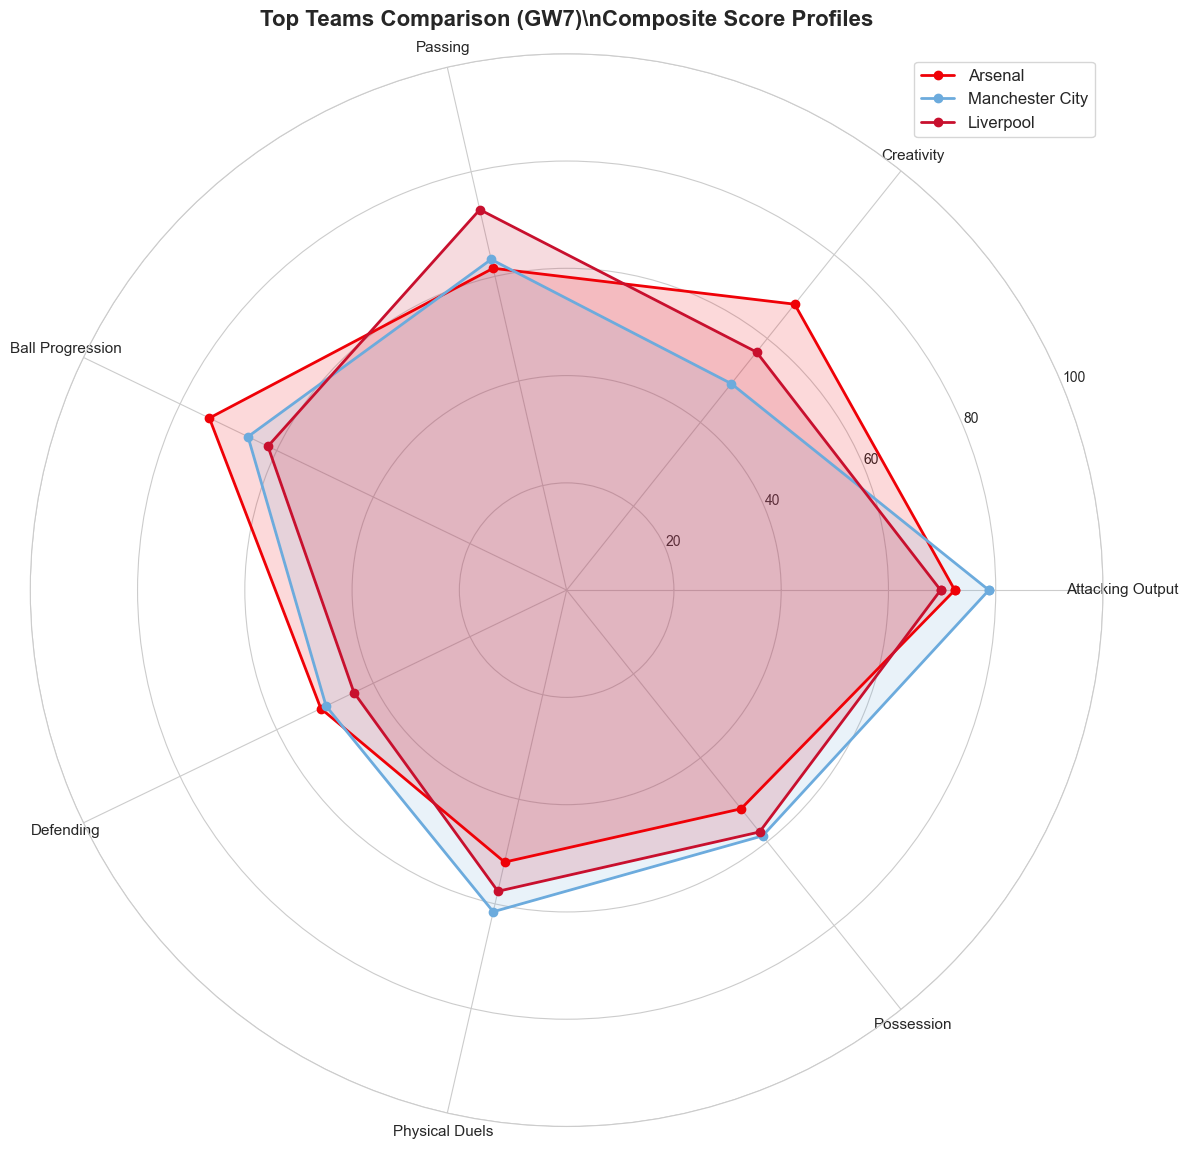

In [58]:
print("=" * 80)
print("SECTION 12B: MULTI-TEAM COMPARISON")
print("=" * 80)
print()

# Define teams to compare
teams_to_compare = ['Arsenal', 'Manchester City', 'Liverpool']

# Create comparison radar chart
if not current_wide.empty:
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

    # Team colors
    team_colors = {
        'Arsenal': '#EF0107',
        'Manchester City': '#6CABDD',
        'Liverpool': '#C8102E'
    }

    categories_clean = [c.replace('_', ' ').title() for c in categories]
    num_vars = len(categories_clean)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    for team in teams_to_compare:
        if team in current_wide['squad_name'].values:
            team_row = current_wide[current_wide['squad_name'] == team].iloc[0]

            # Get scores for all categories
            team_values = [team_row[cat] for cat in categories]
            team_values += team_values[:1]  # Complete the circle

            # Plot
            ax.plot(angles, team_values, 'o-', linewidth=2,
                   label=team, color=team_colors.get(team, '#000000'))
            ax.fill(angles, team_values, alpha=0.15,
                   color=team_colors.get(team, '#000000'))

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories_clean, size=11)
    ax.set_ylim(0, 100)
    ax.set_title("Top Teams Comparison (GW7)\\nComposite Score Profiles",
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.savefig(output_dir / "top_teams_comparison.png", dpi=300, bbox_inches='tight')
    print("✅ Saved: top_teams_comparison.png")
    plt.show()

## Section 14: Summary Report

In [59]:
print("=" * 80)
print("SECTION 13: KEY FINDINGS SUMMARY")
print("=" * 80)
print()

# Create summary report
summary_path = output_dir / "composite_scores_summary.txt"

with open(summary_path, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("COMPOSITE SCORES ANALYSIS SUMMARY - PART 1C\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("ANALYSIS SCOPE\n")
    f.write("-" * 80 + "\n")
    f.write(f"Seasons analyzed: {len(seasons_to_analyze)}\n")
    for season in seasons_to_analyze:
        f.write(f"  - {season}\n")
    f.write(f"Total squad-seasons: {len(historical_with_composites)}\n")
    f.write(f"Categories analyzed: {len(categories)}\n\n")
    
    f.write("STRONGEST PREDICTORS OF FINAL POSITION\n")
    f.write("-" * 80 + "\n")
    for i, (category, corr) in enumerate(correlations_sorted[:5], 1):
        cat_name = category.replace('_score', '')
        f.write(f"{i}. {cat_name:<25} r = {corr:.3f}\n")
    f.write("\n")
    
    f.write("WEAKEST PREDICTORS (Consider Ignoring for ML)\n")
    f.write("-" * 80 + "\n")
    for category, corr in correlations_sorted[-3:]:
        cat_name = category.replace('_score', '')
        f.write(f"  {cat_name:<25} r = {corr:.3f}\n")
    f.write("\n")
    
    f.write("CATEGORY SEPARATION (Top 4 vs Relegation)\n")
    f.write("-" * 80 + "\n")
    for i, (category, sep) in enumerate(separations_sorted[:5], 1):
        cat_name = category.replace('_score', '')
        f.write(f"{i}. {cat_name:<25} {sep:.1f} points difference\n")
    f.write("\n")
    
    if not current_wide.empty and 'Arsenal' in current_wide['squad_name'].values:
        f.write("ARSENAL'S DOMINANCE FACTORS (GW7)\n")
        f.write("-" * 80 + "\n")
        for cat, score in arsenal_scores_sorted[:3]:
            f.write(f"  {cat.replace('_', ' ').title():<25} {score:.1f}\n")
        f.write("\n")
    
    f.write("RECOMMENDATIONS FOR ML MODELING\n")
    f.write("-" * 80 + "\n")
    f.write(f"1. PRIORITIZE these {len(top_predictors)} strong predictors (|r| ≥ 0.5):\n")
    for pred in top_predictors:
        f.write(f"   - {pred.replace('_score', '')}\n")
    f.write("\n")
    
    f.write(f"2. CONSIDER IGNORING these {len(weak_predictors)} weak predictors (|r| < 0.3):\n")
    for pred in weak_predictors:
        f.write(f"   - {pred.replace('_score', '')}\n")
    f.write("\n")
    
    f.write("3. Focus feature engineering on top predictors\n")
    f.write("4. Test if weak predictors add any value in models\n")
    f.write("5. Use historical separation data to weight features\n")

print(f"✅ Summary saved to: {summary_path}")

print()
print("=" * 80)
print("✅ PART 1C: COMPOSITE SCORES ANALYSIS COMPLETE")
print("=" * 80)
print()
print(f"📂 All outputs saved to: {output_dir}")
print(f"\n📊 Files created:")
print(f"   - composite_scores_by_tier.png")
print(f"   - composite_correlation_matrix.png")
print(f"   - arsenal_composite_profile.png")
print(f"   - composite_scores_summary.txt")
print()
print(f"🎯 Next: Review findings and proceed to Part 1D (Correlation Analysis)")

SECTION 13: KEY FINDINGS SUMMARY

✅ Summary saved to: ../../outputs/03_composite_scores_analysis/composite_scores_summary.txt

✅ PART 1C: COMPOSITE SCORES ANALYSIS COMPLETE

📂 All outputs saved to: ../../outputs/03_composite_scores_analysis

📊 Files created:
   - composite_scores_by_tier.png
   - composite_correlation_matrix.png
   - arsenal_composite_profile.png
   - composite_scores_summary.txt

🎯 Next: Review findings and proceed to Part 1D (Correlation Analysis)
